# Part 1 — Data Exploration

In this section, I explore the *Tingvold Large (54)* dataset to understand its content, quality, and potential challenges for Rumex (dock) detection.  
The dataset consists of ~2500 drone images taken from 12 m altitude with a 40° gimbal angle, covering ~31 daa of grassland.

In [8]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np

Fant totalt 2709 bilder fra 5 ruter.


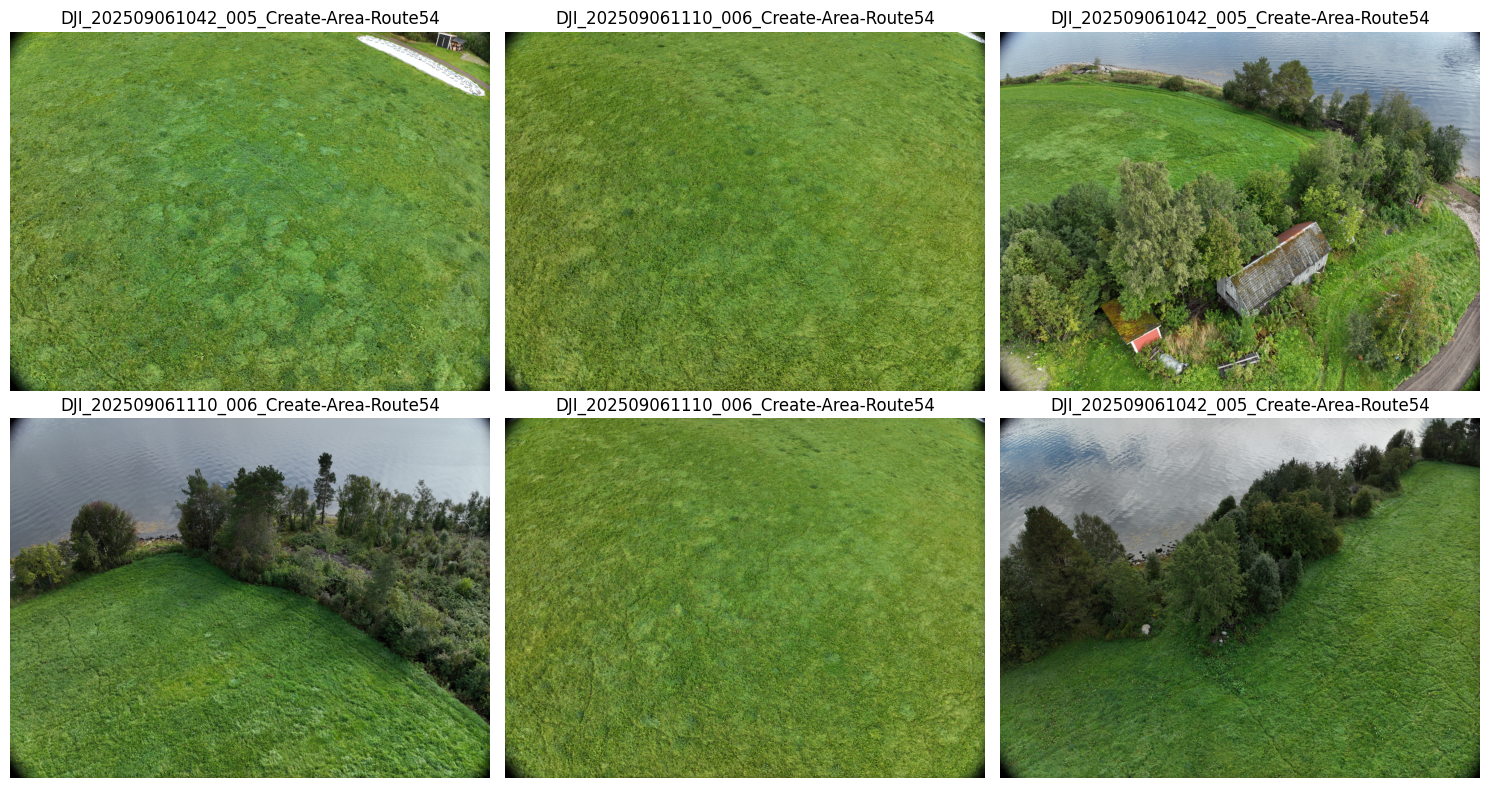

In [9]:
# main data path
base_path = Path("data/54")

# Find all .JPG images in all subfolders (recursively)
image_paths = sorted(base_path.rglob("*.JPG"))
print(f"Fant totalt {len(image_paths)} bilder fra {len(list(base_path.iterdir()))} ruter.")

# Check random images
sample_paths = random.sample(image_paths, 6)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for ax, img_path in zip(axes.flatten(), sample_paths):
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(img_path.parent.name)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Challenges

Trees, buildings, water and roads might become challenges for a model. Differant resolutions might also influence the performance of the model. 

In [10]:
# Number of images per route
route_counts = {}
for img_path in image_paths:
    route_name = img_path.parent.name
    route_counts[route_name] = route_counts.get(route_name, 0) + 1
print("Number of images per route:")
for route, count in route_counts.items():
    print(f"  {route}: {count} images")

# Image dimensions
img_sample = cv2.imread(str(image_paths[0]))
height, width, channels = img_sample.shape
print(f"Image dimensions: {width}x{height} pixels, {channels} channels")

Number of images per route:
  DJI_202509061014_004_Create-Area-Route54: 462 images
  DJI_202509061042_005_Create-Area-Route54: 965 images
  DJI_202509061110_006_Create-Area-Route54: 999 images
  DJI_202509061110_007_Create-Area-Route54: 67 images
  DJI_202509061139_008_Create-Area-Route54: 216 images
Image dimensions: 5280x3956 pixels, 3 channels


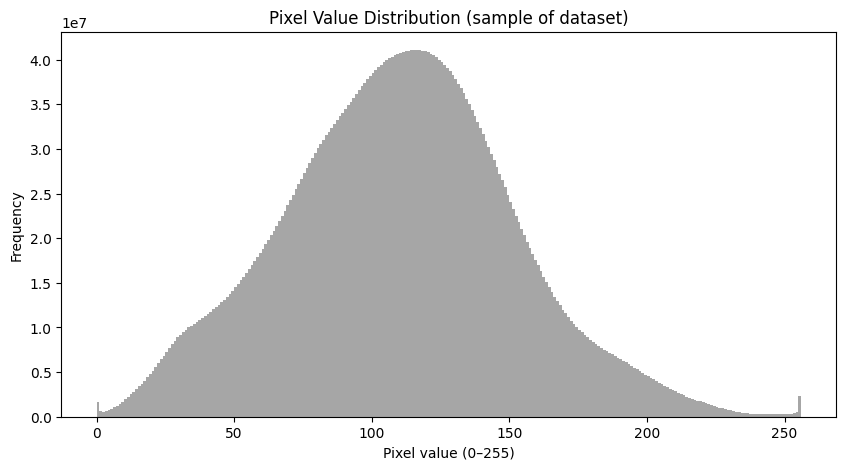

In [ ]:
# Pixel value distribution (grayscale)
# Random sample to save time/memory
sample_paths = random.sample(image_paths, min(len(image_paths), 200))

pixel_values = []
for img_path in sample_paths:
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        pixel_values.append(img.flatten())

# Concatenate into one array
pixel_values = np.concatenate(pixel_values)

plt.figure(figsize=(10, 5))
plt.hist(pixel_values, bins=256, range=(0, 256), color='gray', alpha=0.7)
plt.title("Pixel Value Distribution (sample of dataset)")
plt.xlabel("Pixel value (0–255)")
plt.ylabel("Frequency")
plt.show()

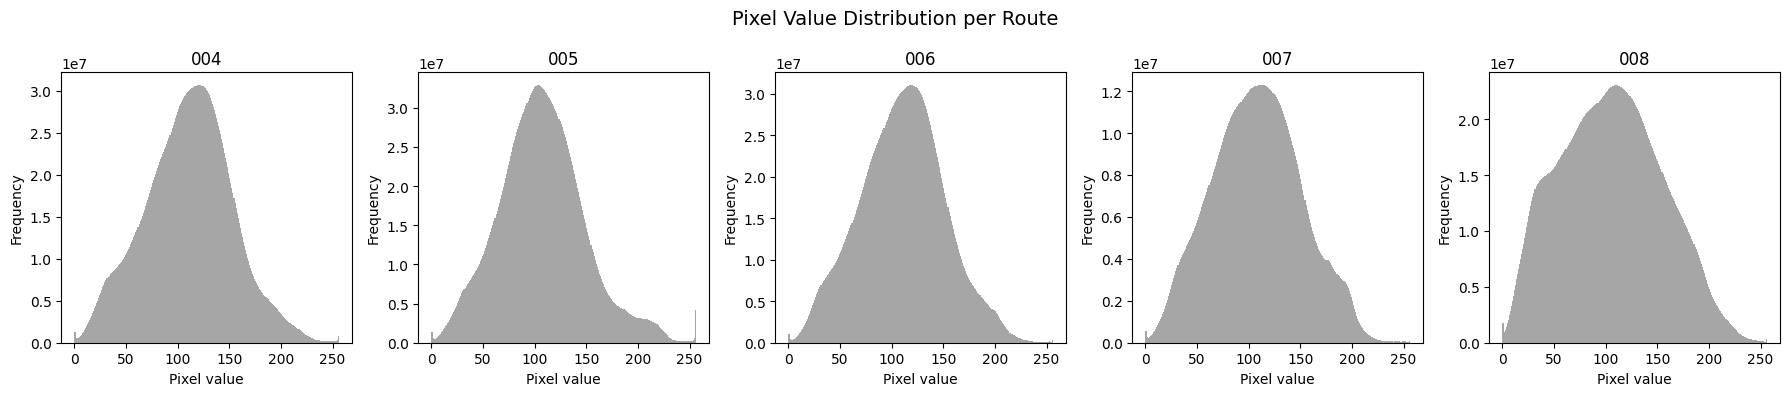

In [12]:
# Pixel value distribution per route
route_dirs = sorted([d for d in base_path.iterdir() if d.is_dir()])

fig, axes = plt.subplots(1, len(route_dirs), figsize=(18, 4))
fig.suptitle("Pixel Value Distribution per Route", fontsize=14)

for ax, route_dir in zip(axes, route_dirs):
    image_paths = list(route_dir.glob("*.JPG"))
    sample_paths = random.sample(image_paths, min(len(image_paths), 150))
    
    pixel_values = []
    for img_path in sample_paths:
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            pixel_values.append(img.flatten())
    
    pixel_values = np.concatenate(pixel_values)
    
    ax.hist(pixel_values, bins=256, range=(0, 256), color='gray', alpha=0.7)
    ax.set_title(route_dir.name.split("_")[2])  # viser f.eks. '004', '005', ...
    ax.set_xlabel("Pixel value")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Pixel Value Distribution Analysis

To examine brightness and contrast across flight routes, I plotted the grayscale pixel value distributions for each route (004–008).

The histograms show that all routes have similar overall brightness distributions, centered roughly between pixel values 80–150.  
This indicates consistent lighting conditions across flights, with only minor variations in exposure. Route 008 appears slightly brighter on average, while route 007 has a narrower distribution suggesting lower contrast.

Overall, the dataset shows good visual consistency, which reduces the need for extensive brightness normalization.  
However, applying mild contrast enhancement or histogram equalization could still improve the visibility of Rumex plants in shaded areas.

## Data to be Labelled

In [1]:
import random
import shutil
from pathlib import Path

# Stier
base_path = Path("data/54")                 # der originalbildene ligger
output_dir = Path("labeled-data/raw_selection")  # ny mappe for utvalgte bilder
output_dir.mkdir(parents=True, exist_ok=True)

# Finn alle ruter
route_dirs = sorted([d for d in base_path.iterdir() if d.is_dir()])

# Samle alle bildebaner (ruter og JPG-filer)
all_images = []
for route_dir in route_dirs:
    imgs = list(route_dir.glob("*.JPG"))
    all_images.extend(imgs)

print(f"Totalt {len(all_images)} bilder funnet i {len(route_dirs)} ruter.")

# Bestem hvor mange du vil ta totalt
n_total = 100

# Fordel omtrent likt mellom rutene
n_per_route = max(1, n_total // len(route_dirs))

selected_images = []
for route_dir in route_dirs:
    imgs = list(route_dir.glob("*.JPG"))
    sample = random.sample(imgs, min(len(imgs), n_per_route))
    selected_images.extend(sample)

# Hvis fordelingen ikke ga nøyaktig 100, fyll på tilfeldig
if len(selected_images) < n_total:
    remaining = list(set(all_images) - set(selected_images))
    extra = random.sample(remaining, n_total - len(selected_images))
    selected_images.extend(extra)

print(f"Valgte totalt {len(selected_images)} bilder.")

# Kopier utvalgte bilder til ny mappe
for img_path in selected_images:
    dest = output_dir / img_path.name
    shutil.copy2(img_path, dest)

print(f"✅  Kopierte {len(selected_images)} bilder til {output_dir}")

Totalt 2709 bilder funnet i 5 ruter.
Valgte totalt 100 bilder.
✅  Kopierte 100 bilder til labeled-data/raw_selection
